![](encabezado.png)

---

# Sondeo Eléctrico Vertical (SEV)

---

Estos métodos son utilizados en el área geológica, geotécnica, ambiental e hidrológica. Se utiliza para mapear características geológicas como litología, estructuras, fracturas y estratigrafía, así como elementos hidrológicos como profundidad del nivel freático, profundidad de un acuífero y salinidad del agua subterránea.

Utiliza una corriente eléctrica inyectada a través de electrodos, la cual es medida e interpretada, con lo que se puede obtener un modelo geoeléctrico del subsuelo.

In [49]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import VESManager
from pygimli.physics import ert
# from pygimli.physics.ves import VESModelling

%matplotlib inline

# Creación del modelo directo

Se crea un modelo de capas con un tamaño especificado e interfases en las profundidades indicadas.

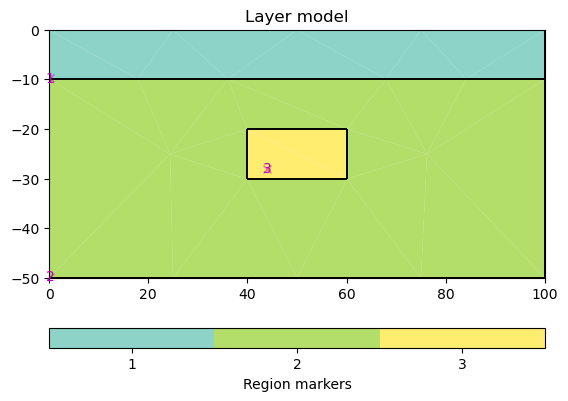

In [50]:
model = mt.createWorld(start=[0,0], end=[100,-50], layers=[-10], worldMarker=True)
rectangulo = mt.createRectangle(start=[40,-20], end=[60,-30], marker=3)

model = model + rectangulo

ax,fig = pg.show(model)
ax.set_title('Layer model')
plt.show()

## Mapeo de resistividades

Se crea una malla con elementos triangulares para aplicar la resolución de las ecuaciones mediante diferencias finitas. Esta malla es creada a través de una triangulación de Delaunay, de manera que ningún vértice de los triángulos debe estar dentro de ninguna circunferencia que circunscriba dichos triángulos.

Cabe destacar que, mientras mayor sea la resolución (menor el tamaño de los triángulos, o mayor el número de puntos), la calidad del modelado será mayor, pero el costo computacional incrementa considerablemente.

Se debe mapear las resistividades deseadas dentro del modelo inicial. Para esto, se crea una lista que contiene listas con el número que indentifica a las regiones del modelo y su resistividad. Esta lista se coloca en la función `pg.solver.parseMapToCellArray()` y se indica el *mesh* en el que se aplicarán los datos.

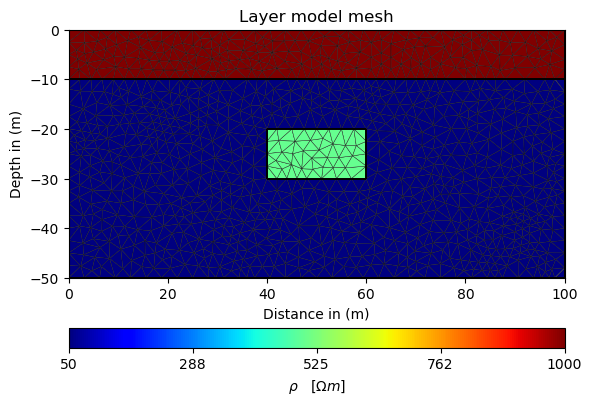

In [51]:
mesh = mt.createMesh(model, quality=34, area=5)

rhomap = [[1,1000.],[2,50.],[3,500.]]
synth = pg.solver.parseMapToCellArray(rhomap, mesh=mesh)

# La función `pg.show()` devuelve un eje y una barra de color
ax, cb = pg.show(mesh, data=rhomap, showMesh=True, cMap='jet')
cb.set_label('$\\rho\quad[\Omega m]$')
ax.set(xlabel='Distance in (m)', ylabel='Depth in (m)')
ax.set_title('Layer model mesh')
plt.show()

## Arreglo de electrodos

Se crea un arreglo Schlumberger con inicio en 5.0, final en 95.0 y 32 electrodos, con separación logarítmica.

La distancia de los electrodos de potencial MN se mantiene constante con una distancia de 1.0

In [52]:
# Número de electrodos
n_elecs = 32

# Creación de los datos sintéticos
scheme = ert.createData(elecs=np.logspace(np.log10(5), np.log10(95), n_elecs), schemeName='slm')

# Posición de los electrodos
ab2 = pg.x(scheme)
# mn2 = np.logspace(np.log10(1), np.log10(30), n_elecs)
mn2 = 1.0

## Respuesta del modelo directo

Se simula la respuesta del modelo, tal cual se recibiría en condiciones ideales. Se aprecia el valor de resistividad y el espesor de la capa como lo indica el modelo inicial.

Se debe crear un vector con los datos de espesor de capa y otro con información de las resistividades para simular la respuesta. Se debe introducir los espaciamientos entre electrodos y el nivel de ruido deseado.

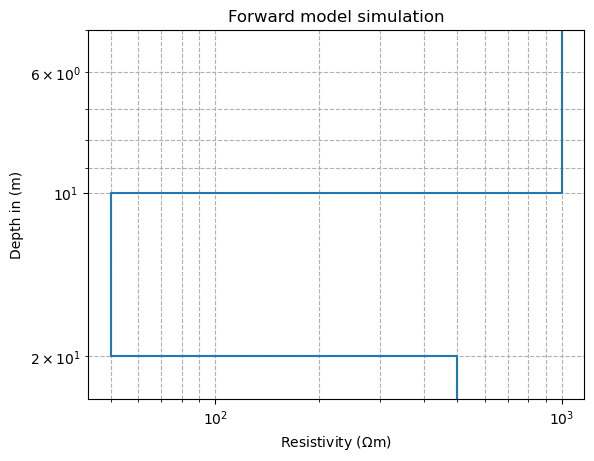

In [53]:
# Datos de resistividad
synth_rho = np.array([1000,50,500], dtype=float)

# Datos de espesor
# La última capa tiene espesor infinito, por lo que no se especifica
synth_thick = np.array([10,10], dtype=float)

# Se crea un arreglo con los datos de espesor y resistividad
synth_model = np.r_[synth_thick, synth_rho]
# synth_model = np.array([synth_thick, synth_rho])

# Manager de la simulación
ves = VESManager()

# Simulación
rhoa, err = ves.simulate(synth_model, ab2=ab2, mn2=mn2, noiseLevel=0.03, seed=1337)

# Visualización del modelo directo
ves.showModel(synth_model)
plt.grid(which='both', ls='--')
plt.title('Forward model simulation')
plt.show()

# Inversión

El método de inversión por default utilizado por PyGimLi es el de **mínimos cuadrados ponderados**, el cual tiene un modelo matemático

$$
\Phi = \Phi_d + \lambda \Phi_m
$$

Este modelo pretende minimizar el valor de la norma L2 entre los datos invertidos $d$ y la respuesta $f$ del modelo directo $m$, ponderado por el factor $\epsilon$

$$
\Phi_d = \sum\limits_i^N \left(\frac{d_i-f_i(m)}{\epsilon_i}\right)^2=\|W_d(d-f(m))\|^2
$$

El factor $\lambda$ se refiere a la regularización aplicada al método de mínimos cuadrados ponderados, donde se compara la respuesta de la inversión con el modelo directo y se le aplica un factor de escala en caso de que la inversión se encuentre muy alejada del modelo directo.

Mientras mayor sea este factor $\lambda$, mayor será la regularización y el modelo tenderá a suavizar más la respuesta de la inversión.

Con el problema propuesto, un valor de $0<\lambda<700$ parece ser el adecuado, ofreciendo un $RMS=3.28\%$


In [54]:
ves.invert(data=rhoa, relativeError=err, ab2=ab2, mn2=mn2, nLayers=2, lam=20, verbose=True)

16/01/24 - 13:27:23 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
16/01/24 - 13:27:23 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.500000/425.460186
16/01/24 - 13:27:23 - pyGIMLi - INFO - Starting inversion.
16/01/24 - 13:27:23 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
16/01/24 - 13:27:23 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
16/01/24 - 13:27:23 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.
16/01/24 - 13:27:23 - pyGIMLi - WARNING - Multiprocess Jacobian currently unavailable for Win32 and Mac.


fop: <pygimli.physics.ves.vesModelling.VESModelling object at 0x000001C67F642770>
Data transformation: <pgcore._pygimli_.RTransLog object at 0x000001C631779630>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001C67F355EE0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x000001C67F5084C0>
min/max (data): 185/958
min/max (error): 1%/1%
min/max (start model): 0.5/425
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 4095.51
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4019.82 (dPhi = 1.85%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 118271.23 (dPhi = -2842.20%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 2929.31 (dPhi = 97.52%) lam: 20.0
------------------------------------------------------------------------

3 [47.49999952499765, 489.18924165554654, 0.006755509798759218]

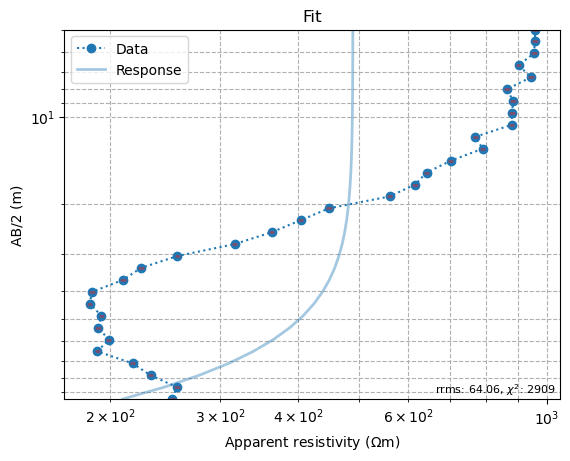

In [55]:
%matplotlib inline
ves.showFit()
plt.grid(which='both', ls='--')
plt.title('Fit')
# plt.gca().invert_yaxis()
plt.show()

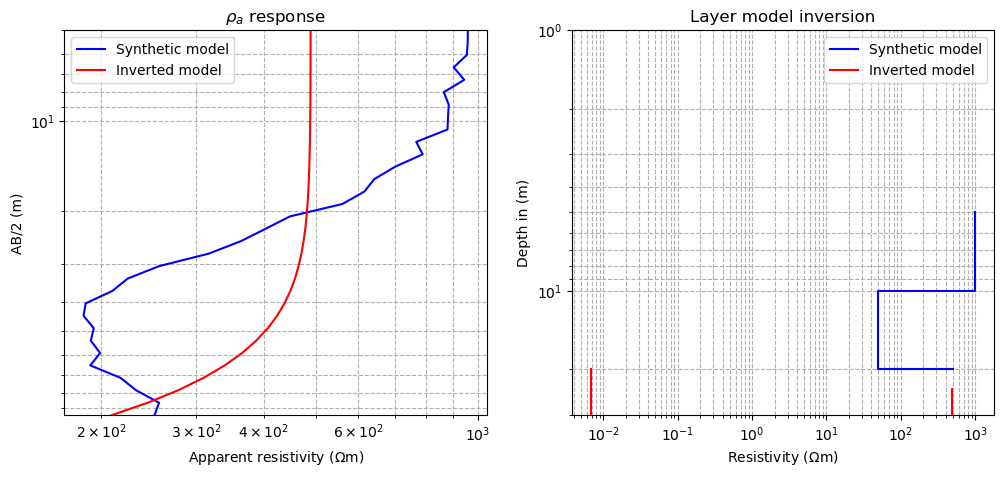

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))


ves.showData(rhoa, color='blue', label='Synthetic model', ax=ax[0])
ves.showData(ves.inv.response, color='red', ax=ax[0], label='Inverted model')
ax[0].grid(which='both', ls='--')
ax[0].set_title(r'$\rho_a$ response')

ves.showModel(synth_model, ax=ax[1], plot='semilogy', zmax=20, label='Synthetic model', color='blue')
ves.showModel(ves.model, ax=ax[1], zmax=20, label='Inverted model', color='red')
ax[1].grid(which='both', ls='--')
ax[1].set_title('Layer model inversion')
plt.ylim(1,30)
plt.gca().invert_yaxis()

plt.legend()
plt.show()